In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier


# fix random seed for more reproducibility and comparability
seed = 7
tf.random.set_seed(seed)

In [31]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_clean.csv')
df

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,1,51.30,2,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,38.72,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,35.17,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,32.78,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,31.51,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,0,0,77.89,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
853,0,1,85.18,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
854,0,0,77.49,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
855,0,1,63.33,2,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [32]:
glioma_type_column = df.iloc[:, 0]
num_zeros = (glioma_type_column == 0).sum()
num_ones = (glioma_type_column == 1).sum()

total_entries = len(glioma_type_column)

percentage_zeros = (num_zeros / total_entries) * 100
percentage_ones = (num_ones / total_entries) * 100

print(f'Percentage of zeros: {percentage_zeros}')
print(f'Percentage of ones: {percentage_ones}')

Percentage of zeros: 42.007001166861144
Percentage of ones: 57.992998833138856


In [33]:
all_inputs = df[df.loc[:, "Gender":].columns.values.tolist()].values

all_labels = df['Grade'].values

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

# Generate the same cross validation strategy for all classifiers for better comparison
cross_validation = StratifiedKFold(n_splits=5)

# Classifier/Model Results dictionary
results = {}

#### Function to test the Model/Classifier

In [34]:
def test_model(model, parameters):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cross_validation, n_jobs=-1)
    grid_result = grid_search.fit(all_inputs, all_labels)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result

### Decision Tree With Hyperparameterization

In [35]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],}

result = test_model(decision_tree_classifier, parameter_grid)

results['Decision Tree'] = result

Best: 0.870475 using {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'splitter': 'best'}
0.596240 (0.019777) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'splitter': 'best'}
0.640711 (0.107210) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'splitter': 'random'}
0.590412 (0.018624) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'splitter': 'best'}
0.661682 (0.102443) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'splitter': 'random'}
0.609126 (0.072702) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 3, 'splitter': 'best'}
0.661676 (0.108064) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 3, 'splitter': 'random'}
0.714300 (0.124573) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 4, 'splitter': 'best'}
0.703896 (0.126418) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 4, 'splitter': 'random'}
0.721134 (0.121752) with: {'criterion': 'gini', 'max_depth': 1, 'max_f

### Neural Network With Hyperparameterization

Based on: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [36]:
# Define the neural network architecture
def create_model(activation='relu'):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(200, activation=activation, input_shape=(n_features,)),
        keras.layers.Dense(200, activation=activation),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [37]:
# Define the neural network architecture
def create_model_without_compile(dropout_rate):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(200, activation='relu', input_shape=(n_features,)),
        keras.layers.Dense(200, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

In [38]:
def create_model_with_dropout(activation='relu', dropout_rate=0.7, neurons=200):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(neurons, activation=activation, input_shape=(n_features,)),
        keras.layers.Dense(neurons, activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

##### Tune Batch Size and Epochs

In [39]:
# # Create Model
# # model = KerasClassifier(model=create_model, verbose=0)
# model = KerasClassifier(model=create_model, verbose=0)

# # Define the grid search parameters
# # The batch size and number of epochs are hyperparameters that can be tuned for optimization
# batch_size = [10, 20, 40, 60, 80, 100]  # Batch size defines the number of samples that will be propagated through the network
# epochs = [10, 50, 100]  # Epochs defines the number times that the learning algorithm will work through the entire training dataset

# parameter_grid = dict(batch_size=batch_size, epochs=epochs)

# result = test_model(model, parameter_grid)

# results['Neural Network'] = result

##### Output from batch_size and epochs tweaking
```
Best: 0.872814 using {'batch_size': 20, 'epochs': 50}
0.865789 (0.010049) with: {'batch_size': 10, 'epochs': 10}
0.865796 (0.010633) with: {'batch_size': 10, 'epochs': 50}
0.864640 (0.005806) with: {'batch_size': 10, 'epochs': 100}
0.801537 (0.097097) with: {'batch_size': 20, 'epochs': 10}
0.872814 (0.006767) with: {'batch_size': 20, 'epochs': 50}
0.865830 (0.013596) with: {'batch_size': 20, 'epochs': 100}
0.866973 (0.010119) with: {'batch_size': 40, 'epochs': 10}
0.865864 (0.032527) with: {'batch_size': 40, 'epochs': 50}
0.868149 (0.011980) with: {'batch_size': 40, 'epochs': 100}
0.859969 (0.009838) with: {'batch_size': 60, 'epochs': 10}
0.861193 (0.030020) with: {'batch_size': 60, 'epochs': 50}
0.861125 (0.016436) with: {'batch_size': 60, 'epochs': 100}
0.851816 (0.021059) with: {'batch_size': 80, 'epochs': 10}
0.864640 (0.009370) with: {'batch_size': 80, 'epochs': 50}
0.870468 (0.015508) with: {'batch_size': 80, 'epochs': 100}
0.834258 (0.024649) with: {'batch_size': 100, 'epochs': 10}
0.872800 (0.015948) with: {'batch_size': 100, 'epochs': 50}
0.863477 (0.007916) with: {'batch_size': 100, 'epochs': 100}

##### Tune optimization algorithm

In [40]:
# # Create Model
# model = KerasClassifier(model=create_model_without_compile, loss="sparse_categorical_crossentropy", epochs=50, batch_size=20, metrics=['accuracy'], verbose=0)

# # Define the grid search parameters
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# parameter_grid = dict(optimizer=optimizer)

# result = test_model(model, parameter_grid)

# results['Neural Network'] = result

```
Best: 0.875133 using {'optimizer': 'Nadam'}
0.689786 (0.108668) with: {'optimizer': 'SGD'}
0.834211 (0.048834) with: {'optimizer': 'RMSprop'}
0.861172 (0.016843) with: {'optimizer': 'Adagrad'}
0.646308 (0.117676) with: {'optimizer': 'Adadelta'}
0.864654 (0.012314) with: {'optimizer': 'Adam'}
0.872821 (0.009925) with: {'optimizer': 'Adamax'}
0.875133 (0.013750) with: {'optimizer': 'Nadam'}


##### Tune Learning Rate and Momentum

In [41]:
# # Create Model
# model = KerasClassifier(model=create_model_without_compile, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# # Define the grid search parameters
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# param_grid = dict(optimizer__learning_rate=learn_rate)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.865837 using {'optimizer__learning_rate': 0.001}
0.865837 (0.017517) with: {'optimizer__learning_rate': 0.001}
0.863477 (0.019749) with: {'optimizer__learning_rate': 0.01}
0.579927 (0.001199) with: {'optimizer__learning_rate': 0.1}
0.548348 (0.063657) with: {'optimizer__learning_rate': 0.2}
0.579927 (0.001199) with: {'optimizer__learning_rate': 0.3}

##### Tune Neuron Activation Function

In [42]:
# # Create Model
# model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# # Define the grid search parameters
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# param_grid = dict(model__activation=activation)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.873983 using {'model__activation': 'softplus'}
0.870488 (0.011188) with: {'model__activation': 'softmax'}
0.873983 (0.011982) with: {'model__activation': 'softplus'}
0.871651 (0.011019) with: {'model__activation': 'softsign'}
0.872807 (0.010116) with: {'model__activation': 'relu'}
0.870454 (0.008916) with: {'model__activation': 'tanh'}
0.870468 (0.004651) with: {'model__activation': 'sigmoid'}
0.869305 (0.008840) with: {'model__activation': 'hard_sigmoid'}
0.865830 (0.013596) with: {'model__activation': 'linear'}


##### Tune Dropout Regularization

In [43]:
# # Create Model
# model = KerasClassifier(model=create_model_with_dropout, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# activation = ["softplus"]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# param_grid = dict(model__activation=activation, model__dropout_rate=dropout_rate)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.875139 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.871624 (0.010696) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.0}
0.869291 (0.010429) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.1}
0.875133 (0.010984) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.2}
0.871624 (0.010036) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.3}
0.870461 (0.008832) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.4}
0.873977 (0.002939) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.5}
0.862288 (0.013843) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.6}
0.875139 (0.008024) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.866973 (0.004508) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.8}
0.866959 (0.010284) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.9}


##### Tune With Best Obtained Parameters

In [44]:
# Create Model
model = KerasClassifier(model=create_model_with_dropout, loss="sparse_categorical_crossentropy", epochs=50, batch_size=20, verbose=0)

learn_rate = [0.001, 0.01]
activation = ["relu","softplus"]
dropout_rate = [0.2, 0.7]
neurons = [32, 64]
optimizer = ['Nadam', 'Adam']
param_grid = dict(model__activation=activation, model__dropout_rate=dropout_rate, model__neurons=neurons, optimizer=optimizer)

result = test_model(model, param_grid)

results['Neural Network'] = result

c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.875133 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 32, 'optimizer': 'Nadam'}
0.871644 (0.009792) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 32, 'optimizer': 'Nadam'}
0.872807 (0.006901) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 32, 'optimizer': 'Adam'}
0.870481 (0.013503) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 64, 'optimizer': 'Nadam'}
0.872807 (0.006901) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 64, 'optimizer': 'Adam'}
0.872807 (0.010116) with: {'model__activation': 'relu', 'model__dropout_rate': 0.7, 'model__neurons': 32, 'optimizer': 'Nadam'}
0.871651 (0.010365) with: {'model__activation': 'relu', 'model__dropout_rate': 0.7, 'model__neurons': 32, 'optimizer': 'Adam'}
0.872821 (0.008454) with: {'model__activation': 'relu', 'model__dropout_rate': 0.7, 'model__neurons': 64, 'o

```
Best: 0.873977 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 64}
0.865810 (0.014778) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 16}
0.871637 (0.009861) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 32}
0.873977 (0.006000) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 64}
0.872800 (0.008756) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 128}
0.862294 (0.012195) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 256}
0.870481 (0.002121) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 512}


In [45]:
Grade = df.pop('Grade')
x_train, x_test, y_train, y_test = train_test_split(df, Grade, test_size=0.25)
RandomForest = RandomForestClassifier()
RandomForest.fit(x_train, y_train)

RandomForestClassifier()

#### Random Forest with Hyperparemetrization

In [46]:
parameter_grid = {
    'n_estimators': [10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

result = test_model(RandomForest, parameter_grid)

results['Random Forest'] = result

Best: 0.879825 using {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
0.868142 (0.012061) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.862308 (0.009527) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
0.874004 (0.013883) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
0.870502 (0.013283) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.870488 (0.017028) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
0.865823 (0.012662) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
0.870495 (0.012841) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 

In [47]:
# y_predicted = RandomForest.predict(x_test)
# y_proba = RandomForest.predict_proba(x_test)[:, 1]
# cm = confusion_matrix(y_test, y_predicted)

# RandomForest_accuracy = accuracy_score(y_test, y_predicted)
# print(f'Accuracy: {RandomForest_accuracy}')
# RandomForest_report = classification_report(y_test, y_predicted, target_names=['LGG', 'GBM' ])
# print(RandomForest_report)
# RandomForest_roc_auc = roc_auc_score(y_test, y_proba)
# print(f'ROC AUC: {RandomForest_roc_auc}')


### Naives Bayes Classifier with Hyperparameterization

#### Gaussian Naives Bayes


In [48]:
GaussianNaivesBayes = GaussianNB()
GaussianNaivesBayes.fit(x_train, y_train)

gnb_param_grid = {
    # There are no hyperparameters to tune for GaussianNB
}

gnb_grid_result = test_model(GaussianNaivesBayes, gnb_param_grid)

results['GaussianNaivesBayes'] = gnb_grid_result

Best: 0.802958 using {}
0.802958 (0.068119) with: {}


In [49]:
# y_predicted = GaussianNaivesBayes.predict(x_test)
# y_proba = GaussianNaivesBayes.predict_proba(x_test)[:, 1]

# GaussianNaivesBayes_accuracy = accuracy_score(y_test, y_predicted)
# print(f'Accuracy: {GaussianNaivesBayes_accuracy}')

# GaussianNaivesBayes_report = classification_report(y_test, y_predicted, target_names=['LGG', 'GBM' ])
# print(GaussianNaivesBayes_report)

# GaussianNaivesBayes_roc_auc = roc_auc_score(y_test, y_proba)
# print(f'ROC AUC: {GaussianNaivesBayes_roc_auc}')

#### Multinomial Naives Bayes

In [50]:
MultinomialNaivesBayes = MultinomialNB()
MultinomialNaivesBayes.fit(x_train, y_train)

mnb_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

mnb_grid_result = test_model(MultinomialNaivesBayes, mnb_param_grid)

results['MultinomialNaivesBayes'] = mnb_grid_result

Best: 0.872827 using {'alpha': 2.0}
0.870488 (0.012911) with: {'alpha': 0.001}
0.870488 (0.012911) with: {'alpha': 0.01}
0.870488 (0.012911) with: {'alpha': 0.1}
0.871658 (0.012116) with: {'alpha': 0.5}
0.871658 (0.012116) with: {'alpha': 1.0}
0.872827 (0.014362) with: {'alpha': 2.0}
0.870502 (0.016894) with: {'alpha': 5.0}
0.869325 (0.015795) with: {'alpha': 10.0}


In [51]:
# y_predicted = MultinomialNaivesBayes.predict(x_test)
# y_proba = MultinomialNaivesBayes.predict_proba(x_test)[:, 1]

# MultinomialNaivesBayes_accuracy = accuracy_score(y_test, y_predicted)
# print(f'Accuracy: {MultinomialNaivesBayes_accuracy}')

# MultinomialNaivesBayes_report = classification_report(y_test, y_predicted, target_names=['LGG', 'GBM' ])
# print(MultinomialNaivesBayes_report)

# MultinomialNaivesBayes_roc_auc = roc_auc_score(y_test, y_proba)
# print(f'ROC AUC: {MultinomialNaivesBayes_roc_auc}')

#### Bernoulli Naives Bayes

In [52]:
BernoulliNaivesBayes = BernoulliNB()
BernoulliNaivesBayes.fit(x_train, y_train)

bnb_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  
}

bnb_grid_result = test_model(BernoulliNaivesBayes, bnb_param_grid)

results['BernoulliNaivesBayes'] = bnb_grid_result

Best: 0.870502 using {'alpha': 0.001}
0.870502 (0.015209) with: {'alpha': 0.001}
0.870502 (0.015209) with: {'alpha': 0.01}
0.870502 (0.015209) with: {'alpha': 0.1}
0.870502 (0.015209) with: {'alpha': 0.5}
0.870495 (0.015273) with: {'alpha': 1.0}
0.870488 (0.012911) with: {'alpha': 2.0}
0.868149 (0.015469) with: {'alpha': 5.0}
0.863498 (0.016601) with: {'alpha': 10.0}


In [53]:
# y_predicted = BernoulliNaivesBayes.predict(x_test)
# y_proba = BernoulliNaivesBayes.predict_proba(x_test)[:, 1]

# accuracy = accuracy_score(y_test, y_predicted)
# print(f'Accuracy: {accuracy}')

# report = classification_report(y_test, y_predicted, target_names=['LGG', 'GBM' ])
# print(report)

# roc_auc = roc_auc_score(y_test, y_proba)
# print(f'ROC AUC: {roc_auc}')

#### Support Vector Machine (SVM) with Hyperparameterization

In [54]:
svm = SVC(probability=True)
svm.fit(x_train, y_train)

parameter_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],         
    'degree': [2, 3, 4],   
    'class_weight': [None, 'balanced'], 
    'probability': [True]             
}
result = test_model(svm, parameter_grid)

results['Support Vector Machine'] = result

Best: 0.870502 using {'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'auto', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'auto', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 4, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 4, 'gamma': 'auto', 'probability': True}
0.728145 (0.031240) with: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'probability': True}
0.739834 (0.028338) with: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'auto', 'probability': True

In [55]:
# y_predicted = svm.predict(x_test)
# y_proba = svm.predict_proba(x_test)[:, 1]

# accuracy = accuracy_score(y_test, y_predicted)
# print(f'Accuracy: {accuracy}')

# report = classification_report(y_test, y_predicted, target_names=['LGG', 'GBM' ])
# print(report)

# roc_auc = roc_auc_score(y_test, y_proba)
# print(f'ROC AUC: {roc_auc}')

#### K Nearest Neighboors

In [56]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

parameter_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 50],
    'p': [1, 2]
}
result = test_model(knn, parameter_grid)

results['K Nearest Neighbors'] = result

Best: 0.835475 using {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.801680 (0.022345) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.793506 (0.022570) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.801680 (0.022345) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.793506 (0.022570) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.807494 (0.012377) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.800503 (0.017783) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.807494 (0.012377) with: {'algorithm': 'auto', 'l

In [57]:
# y_predicted = knn.predict(x_test)
# y_proba = knn.predict_proba(x_test)[:, 1]

# accuracy = accuracy_score(y_test, y_predicted)
# print(f'Accuracy: {accuracy}')

# report = classification_report(y_test, y_predicted, target_names=['LGG', 'GBM' ])
# print(report)

# roc_auc = roc_auc_score(y_test, y_proba)
# print(f'ROC AUC: {roc_auc}')

Accuracy for Decision Tree: 0.5162790697674419
ROC AUC for Decision Tree: 0.9054629629629629


c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy for Neural Network: 0.5162790697674419
ROC AUC for Neural Network: 0.9281481481481481
Accuracy for Random Forest: 0.5209302325581395
ROC AUC for Random Forest: 0.9719907407407408
Accuracy for GaussianNaivesBayes: 0.5069767441860465
ROC AUC for GaussianNaivesBayes: 0.9055555555555554
Accuracy for MultinomialNaivesBayes: 0.5255813953488372


c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


ROC AUC for MultinomialNaivesBayes: 0.9161111111111111
Accuracy for BernoulliNaivesBayes: 0.5162790697674419
ROC AUC for BernoulliNaivesBayes: 0.919212962962963
Accuracy for Support Vector Machine: 0.5162790697674419
ROC AUC for Support Vector Machine: 0.9311111111111111


c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but BernoulliNB was fitted without feature names
  warnings.warn(
c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy for K Nearest Neighbors: 0.5162790697674419
ROC AUC for K Nearest Neighbors: 0.9406018518518519


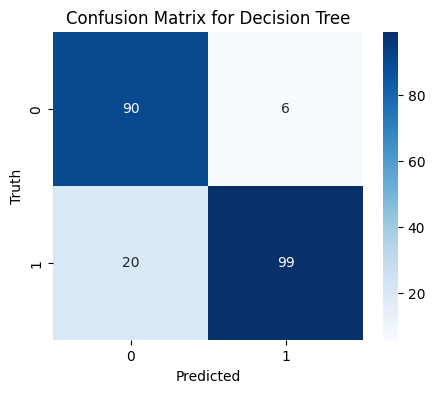

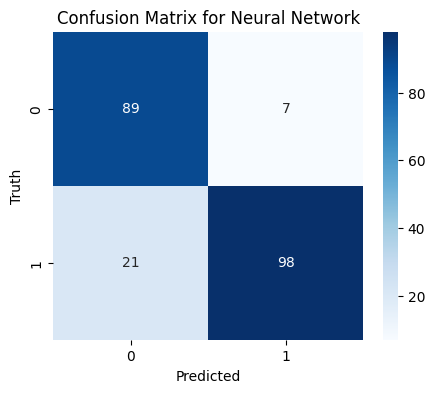

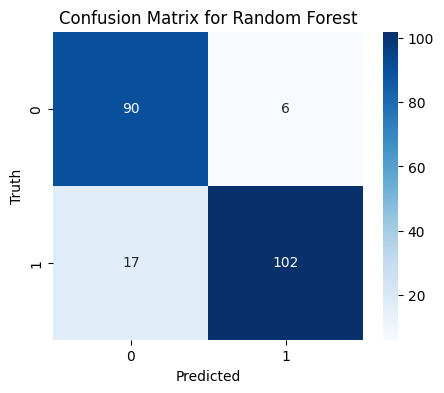

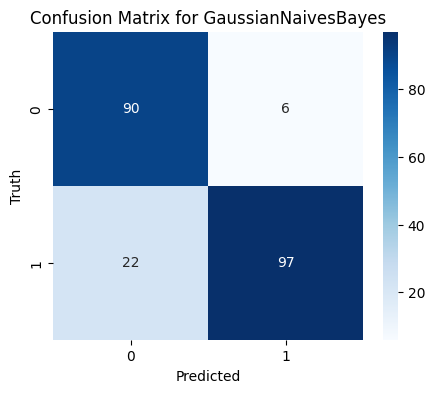

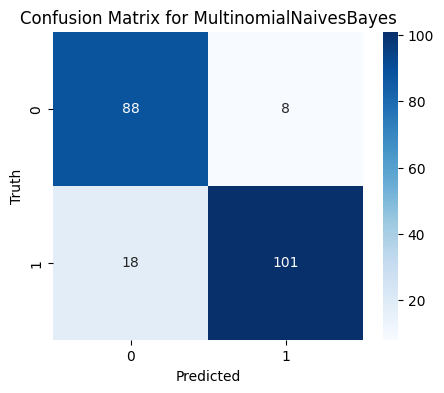

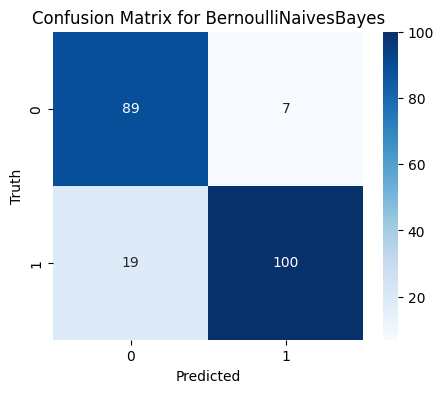

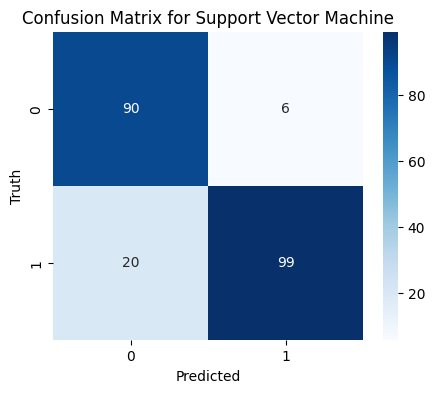

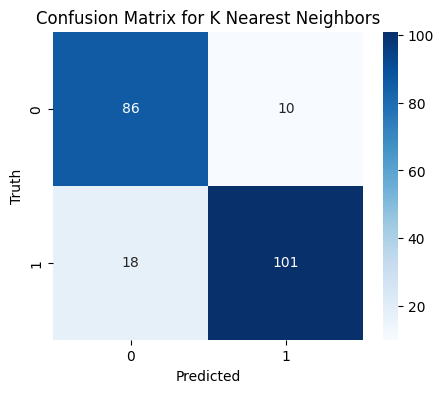

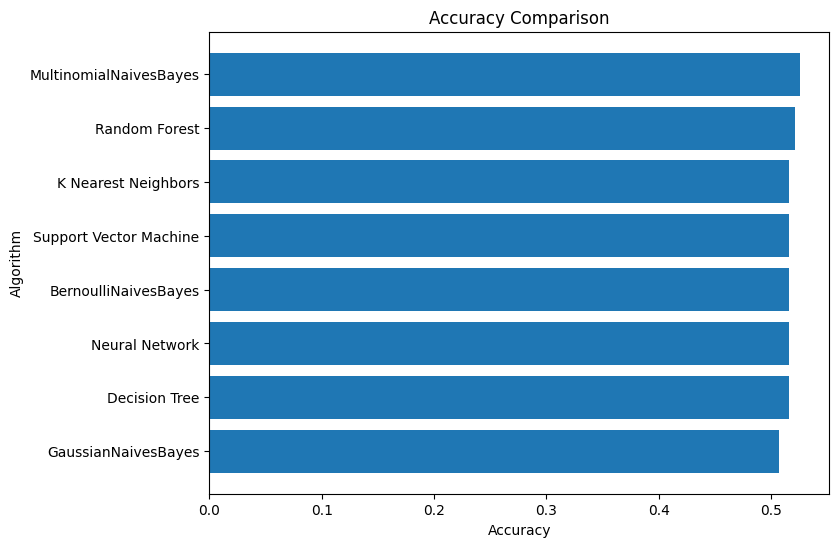

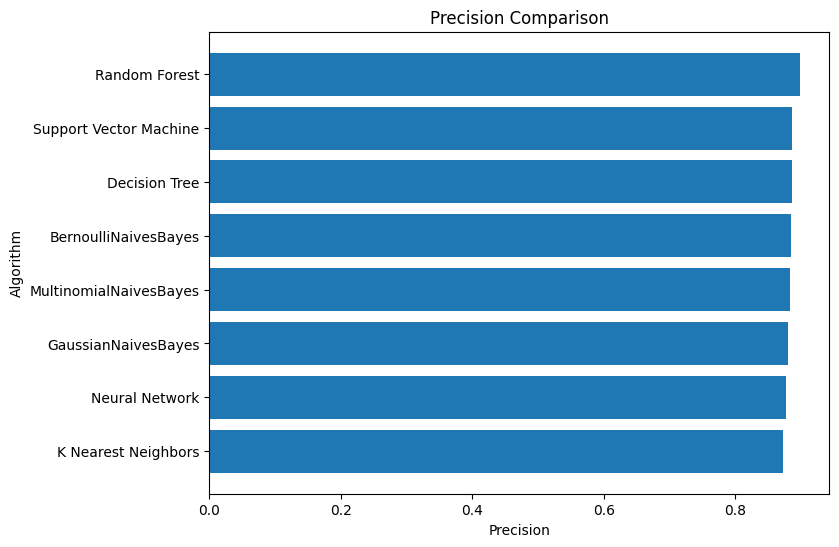

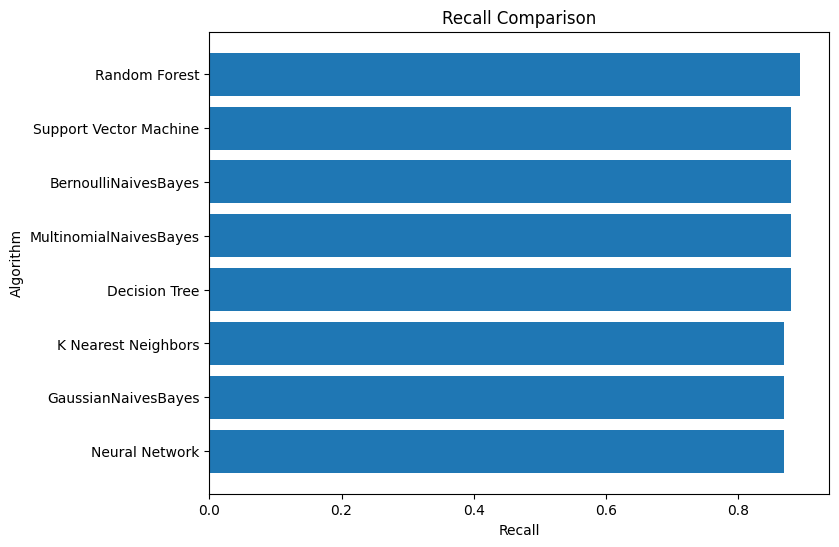

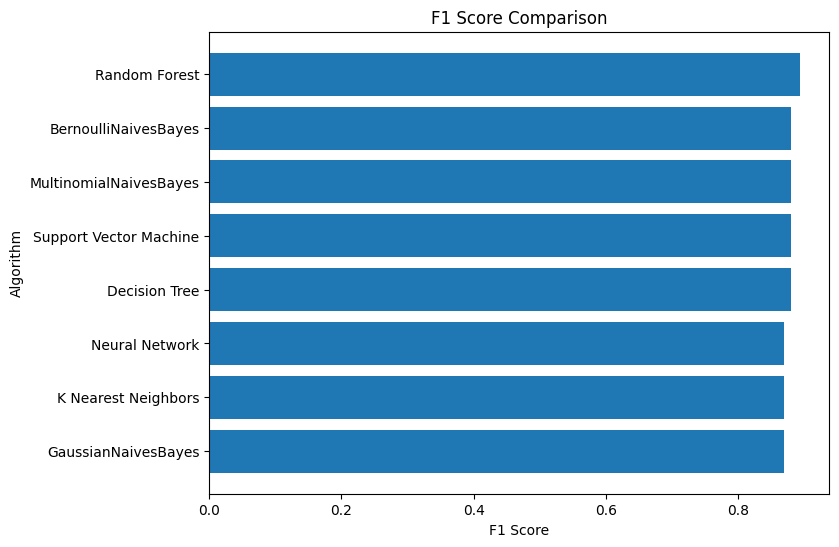

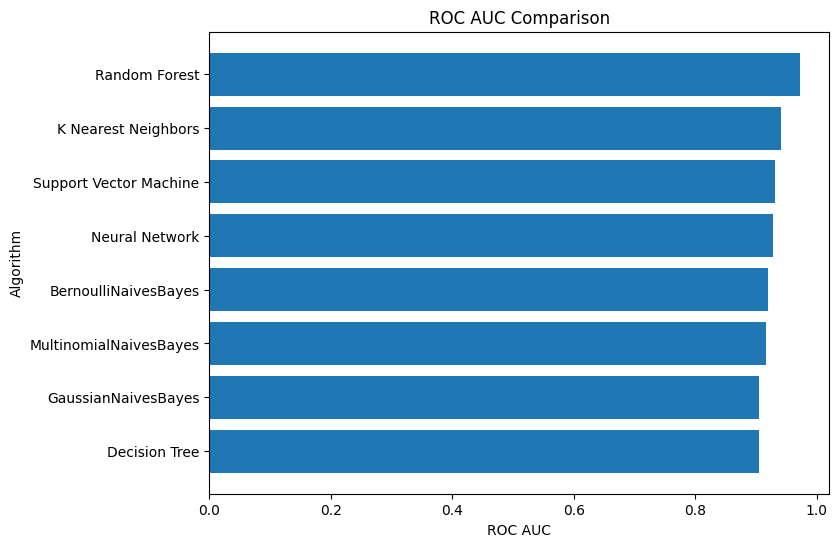

In [58]:
metrics = {}
for key in results:
    # Predict the values from the validation dataset
    y_predicted = results[key].best_estimator_.predict(testing_inputs)
    y_proba = results[key].best_estimator_.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_predicted)
    print(f'Accuracy for {key}: {accuracy}')

    weighted_precision = precision_score(testing_classes, y_predicted, average='weighted')
    weighted_recall = recall_score(testing_classes, y_predicted, average='weighted')
    weighted_f1_score = f1_score(testing_classes, y_predicted, average='weighted')

    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC for {key}: {roc_auc}')

    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(y_predicted)

    # Create the confusion matrix
    cm = confusion_matrix(testing_classes, y_predicted)

    metrics[key] = {
        'Accuracy': accuracy,
        'Precision': weighted_precision,
        'Recall': weighted_recall,
        'F1 Score': weighted_f1_score,
        'ROC AUC': roc_auc
    }

    plt.figure(figsize=(5, 4))
    sb.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.title('Confusion Matrix for ' + key)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

import matplotlib.pyplot as plt

type_of_metric = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

for metric in type_of_metric:
    data = {}
    for algorithm in metrics.keys():
        data[algorithm] = metrics[algorithm][metric]
    plt.figure(figsize=(8, 6))
    plt.title(f'{metric} Comparison')
    plt.xlabel(metric)
    plt.ylabel('Algorithm')

    # Sort the data in descending order
    sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=False)
    sorted_algorithms = [item[0] for item in sorted_data]
    sorted_values = [item[1] for item in sorted_data]

    # Plot the sorted data
    plt.barh(sorted_algorithms, sorted_values)

    plt.title(f'{metric} Comparison')
    plt.xlabel(metric)
    plt.ylabel('Algorithm')
    plt.show()


## Evaluation Metrics and Algorithm Performance

When evaluating the performance of different algorithms, it is important to consider the specific evaluation metric that is most relevant to your task. Here are some insights into the performance of different algorithms based on various evaluation metrics:

### Accuracy

If the primary evaluation metric is Accuracy, the algorithms that exhibit superior performance are the Neural Network and Support Vector Machine (SVM).

### Minimizing False Positives (Precision)

In situations where the priority is to minimize false positives, the Random Forest algorithm is the most suitable choice. It consistently demonstrates exceptional performance in this regard.

### Minimizing False Negatives (Recall)

When the critical requirement is to minimize false negatives, the Random Forest algorithm again demonstrates exceptional performance. It effectively reduces the occurrence of false negatives.

### Balancing False Positives and False Negatives (F1 Score)

If the objective is to strike a balance between minimizing false positives and false negatives, as measured by the F1 Score, the Random Forest algorithm consistently appears to be the most effective solution.

### Balancing True Positives and False Positives (AUC-ROC)

In the context of balancing true positives and false positives, as quantified by the AUC-ROC metric, the Neural Network and Random Forest algorithms emerge as the leading options.

By considering these insights, you can choose the most appropriate algorithm based on your specific evaluation metric and requirements.